In [1]:
import bayes3d as b
import bayes3d.genjax
import genjax
import jax.numpy as jnp
import jax
import os
from tqdm import tqdm
console = genjax.pretty(show_locals=False)
from genjax._src.core.transforms.incremental import NoChange
from genjax._src.core.transforms.incremental import UnknownChange
from genjax._src.core.transforms.incremental import Diff

In [2]:
b.setup_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7017/static/


In [140]:
intrinsics = b.Intrinsics(
    height=100,
    width=100,
    fx=500.0, fy=500.0,
    cx=50.0, cy=50.0,
    near=0.01, far=20.0
)

b.setup_renderer(intrinsics)
model_dir = os.path.join(b.utils.get_assets_dir(),"bop/ycbv/models")
meshes = []
for idx in range(1,22):
    mesh_path = os.path.join(model_dir,"obj_" + "{}".format(idx).rjust(6, '0') + ".ply")
    b.RENDERER.add_mesh_from_file(mesh_path, scaling_factor=1.0/1000.0)

# b.RENDERER.add_mesh_from_file(os.path.join(b.utils.get_assets_dir(), "sample_objs/cube.obj"), scaling_factor=1.0/1000000000.0)

[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (128, 128, 1024)


In [141]:
# del importance_jit
importance_jit = jax.jit(b.genjax.model.importance)
key = jax.random.PRNGKey(5)

In [142]:
@genjax.gen
def single_object_model():
    pose = b.genjax.uniform_pose(jnp.array([-0.01,-0.01,1.5]), jnp.array([0.01,0.01,3.5])) @ "pose"
    obj_id = 0
    rendered = b.RENDERER.render(
        pose[None,...] , jnp.array([obj_id])
    )[...,:3]
    image = b.genjax.image_likelihood(rendered, 0.01, 0.01, 1.0) @ "image"
    return rendered

importance_jit = jax.jit(single_object_model.importance)
key = jax.random.PRNGKey(5)

38329.45


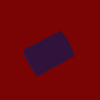

In [143]:
key, (_,gt_trace) = importance_jit(key, genjax.choice_map({}), ())
print(gt_trace.get_score())
b.get_depth_image(gt_trace["image"][...,2])

In [144]:
importance_parallel = jax.jit(jax.vmap(single_object_model.importance, in_axes=(0, None, None)))

In [145]:
keys = jax.random.split(key, 1000)
keys, (weights, traces) = importance_parallel(keys, genjax.choice_map({"image": gt_trace["image"]}), ());

In [146]:
traces.get_retval().shape

(1000, 100, 100, 3)

In [147]:
sampled_indices = jax.random.categorical(key, weights, shape=(10,))
print(sampled_indices)
print(weights[sampled_indices])
images = [b.get_depth_image(img[:,:,2]) for img in traces.get_retval()[sampled_indices]]

[362 362 362 362 362 362 362 362 362 362]
[37816.703 37816.703 37816.703 37816.703 37816.703 37816.703 37816.703
 37816.703 37816.703 37816.703]


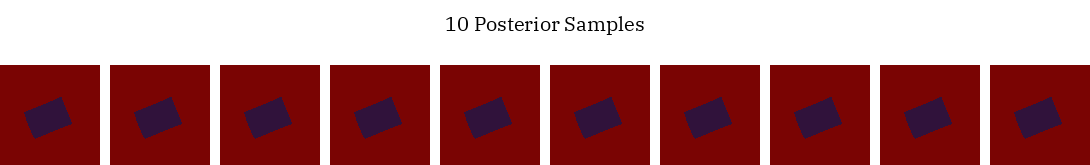

In [148]:
b.multi_panel(images,title="10 Posterior Samples", title_fontsize=20).convert("RGB")

In [26]:
variance, concentration = 0.001, 0.001

Array([[ 7.2428358e-01, -5.3898275e-01, -4.3001282e-01, -8.8510322e-05],
       [ 2.4983856e-01, -3.7612528e-01,  8.9225030e-01, -7.5911818e-04],
       [-6.4264619e-01, -7.5367594e-01, -1.3776267e-01,  1.0006614e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  1.0000000e+00]],      dtype=float32)

In [37]:
def importance_sampling_with_proposal(key, trace, variance, concentration):
    pose_mean = b.transform_from_pos(jnp.array([0.0, 0.0, 1.0]))
    pose = b.distributions.gaussian_vmf_jit(key, pose_mean, variance, concentration)
    proposal_weight = b.distributions.gaussian_vmf_logpdf_jit(pose, pose_mean, variance, concentration)
    new_trace = trace.update(key, genjax.choice_map({"root_pose_0": pose}), 
                             b.genjax.make_unknown_change_argdiffs(trace))[1][2]
    return new_trace,new_trace.get_score() - proposal_weight
importance_sampling_with_proposal_vmap = jax.vmap(importance_sampling_with_proposal, in_axes=(0, None, None, None))

In [46]:
traces, weights = importance_sampling_with_proposal_vmap(jax.random.split(key, 100), gt_trace, 0.001, 0.001)

[13 13 13 13 13 13 13 13 13 13]
[16898.512 16898.512 16898.512 16898.512 16898.512 16898.512 16898.512
 16898.512 16898.512 16898.512]


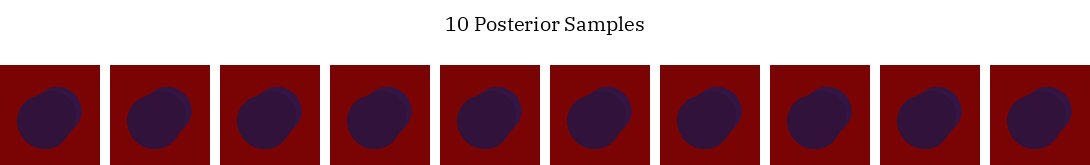

In [47]:
sampled_indices = jax.random.categorical(key, weights, shape=(10,))
print(sampled_indices)
print(weights[sampled_indices])
images = [b.get_depth_image(img[:,:,2]) for img in b.genjax.get_rendered_image(traces)[sampled_indices]]
b.multi_panel(images,title="10 Posterior Samples", title_fontsize=20).convert("RGB")